In [1]:
import sys
sys.path.append("../../")

import bayesflow as bf
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork

from summary import CustomSummary
from evaluation import eval_performance

2023-12-06 18:58:42.171759: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 18:58:42.194651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 18:58:42.523611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/radevs/anaconda3/envs/BayesFlowDev/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonot

## Data Loading and Configuration

In [2]:
def read_offline_data(obs_path, param_path, validation_ratio: float = 0.02):
    assert(len(obs_path) == len(param_path))
    observables = []
    params = []
    for i in range(len(obs_path)):
        observables.append(pd.read_pickle(obs_path[i]))
        params.append(pd.read_pickle(param_path[i]))
    obs = np.stack(pd.concat(observables).to_numpy())
    tumor_size = np.stack(obs[:,0])[:, :, None].astype(np.float32)
    radial_features = np.stack([np.stack(obs[:,1]),np.stack(obs[:,2])], axis=-1)[:,:300,:].astype(np.float32)
    params = pd.concat(params).to_numpy().astype(np.float32)
    split = int(validation_ratio * params.shape[0])
    train = {"prior_draws": params[split:], 
             "sim_data": radial_features[split:], 
             'growth_curve': tumor_size[split:]}
    validation = {"prior_draws": params[:split], 
                  "sim_data": radial_features[:split], 
                  'growth_curve': tumor_size[:split]}    
    return train, validation

In [3]:
def configure_input(forward_dict):
    """Custom configurator."""
    
    out_dict = {}
    pp_ecmp = (forward_dict['sim_data'] - MEAN_SIM) / STD_SIM
    pp_ecmp = np.c_[pp_ecmp, [POSITIONAL_EMBEDDINGS]*pp_ecmp.shape[0]]
    growth =  (forward_dict['growth_curve'] - MEAN_GROWTH) / STD_GROWTH 
    params = forward_dict['prior_draws']
    
    out_dict = {
        'summary_conditions': (pp_ecmp, growth),
        'parameters': params
    }    
    return out_dict

In [4]:
train_data, val_data = read_offline_data(
    obs_path=['../../tumor_data/observables_10000_1.pkl', '../../tumor_data/observables_10000_2.pkl'],
    param_path=['../../tumor_data/params_10000_1.pkl', '../../tumor_data/params_10000_2.pkl']
)

In [5]:
MEAN_GROWTH = train_data['growth_curve'].mean((0, 1))
STD_GROWTH = train_data['growth_curve'].std((0, 1))
MEAN_SIM = train_data['sim_data'].mean((0, 1))
STD_SIM = train_data['sim_data'].std((0, 1))
MEAN_PARAMS = train_data['prior_draws'].mean((0, 1))
STD_PARAMS = train_data['prior_draws'].mean((0, 1))

## Networks

In [6]:
BATCH_SIZE = 64
EPOCHS = 300
POSITIONAL_EMBEDDINGS = np.linspace(0, 1, train_data['sim_data'].shape[1], dtype=np.float32)[:, None]

In [7]:
ITERATIONS = int(np.ceil((train_data['sim_data'].shape[0] / BATCH_SIZE))*EPOCHS)

In [8]:
summary_net = CustomSummary()

inference_net = InvertibleNetwork(
    num_params=train_data['prior_draws'].shape[-1],
    coupling_design='spline',
    permutation='learnable',
    coupling_settings={
        'dense_args': {'units': 128, 'activation': 'relu'},
        'dropout': 0.2
    }
)


amortizer = AmortizedPosterior(
    inference_net=inference_net, 
    summary_net=summary_net
)

2023-12-06 18:58:46.914434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 18:58:46.929786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 18:58:46.929888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Consistency Trainer

In [9]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    configurator=configure_input,
    checkpoint_path='ckpt/nsf',
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from ckpt/nsf/history_300.pkl.
INFO:root:Networks loaded from ckpt/nsf/ckpt-300


In [10]:
# h = trainer.train_offline(
#     train_data, 
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE, 
#     validation_sims=val_data
# )

## Quick Validation

In [10]:
conf = configure_input(val_data)
p = eval_performance(conf, amortizer, n_samples=2000, scale=(MEAN_PARAMS, STD_PARAMS))
p

2023-12-06 18:58:51.243801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-06 18:58:51.405320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-06 18:58:52.257269: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x6fa7270


{'time': 4.149644346995046,
 'MaxECE': 0.023486842105263153,
 'MeanECE': 0.015093984962406017,
 'MedianECE': 0.01559210526315789,
 'MinECE': 0.006710526315789486,
 'RMSE': 0.58974}

In [13]:
samples = amortizer.sample(conf, n_samples=500, to_numpy=False)

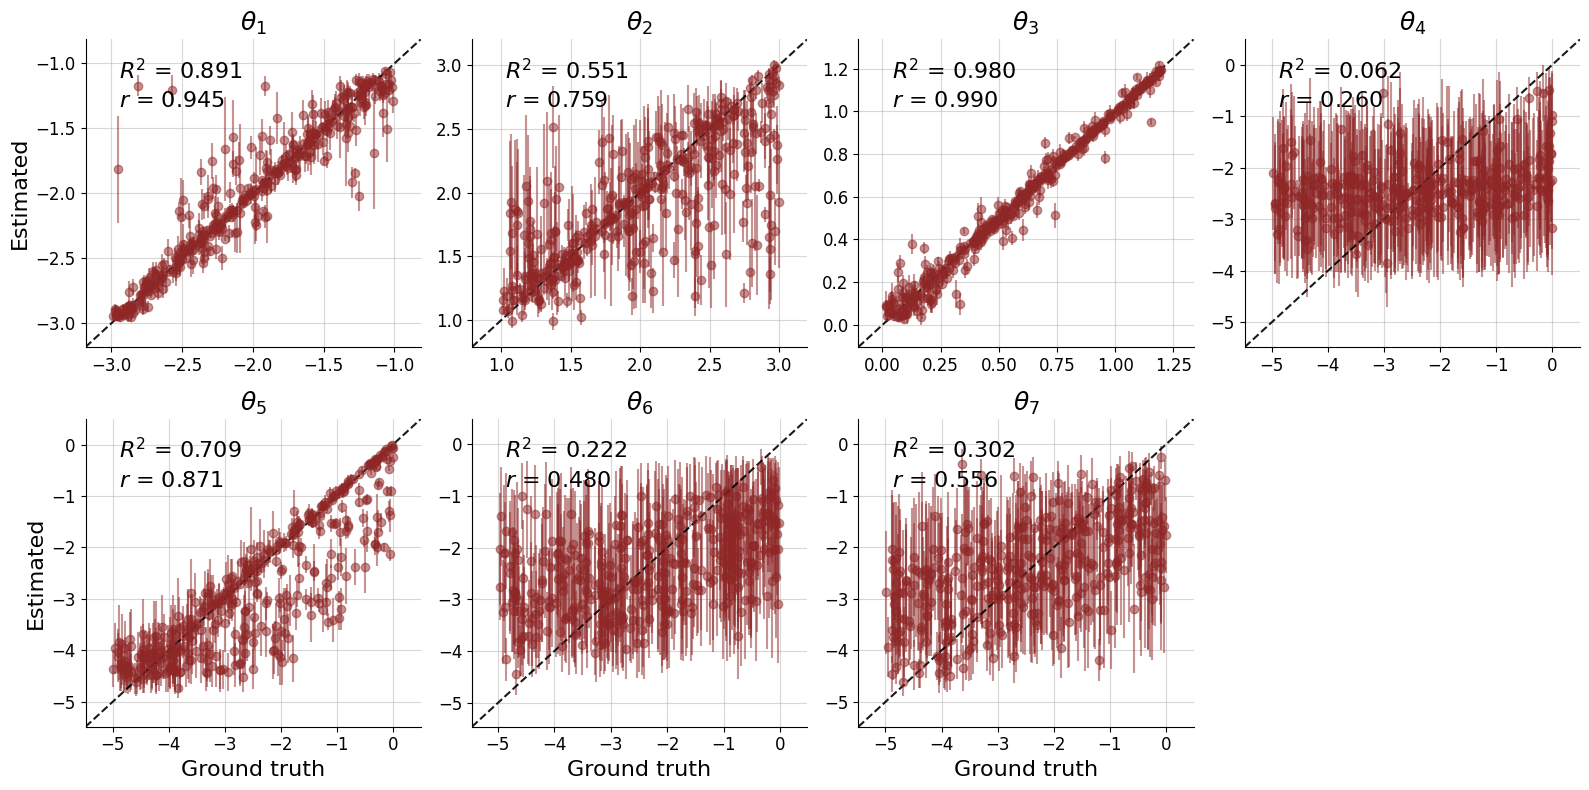

In [14]:
f = bf.diagnostics.plot_recovery(samples, conf['parameters'])

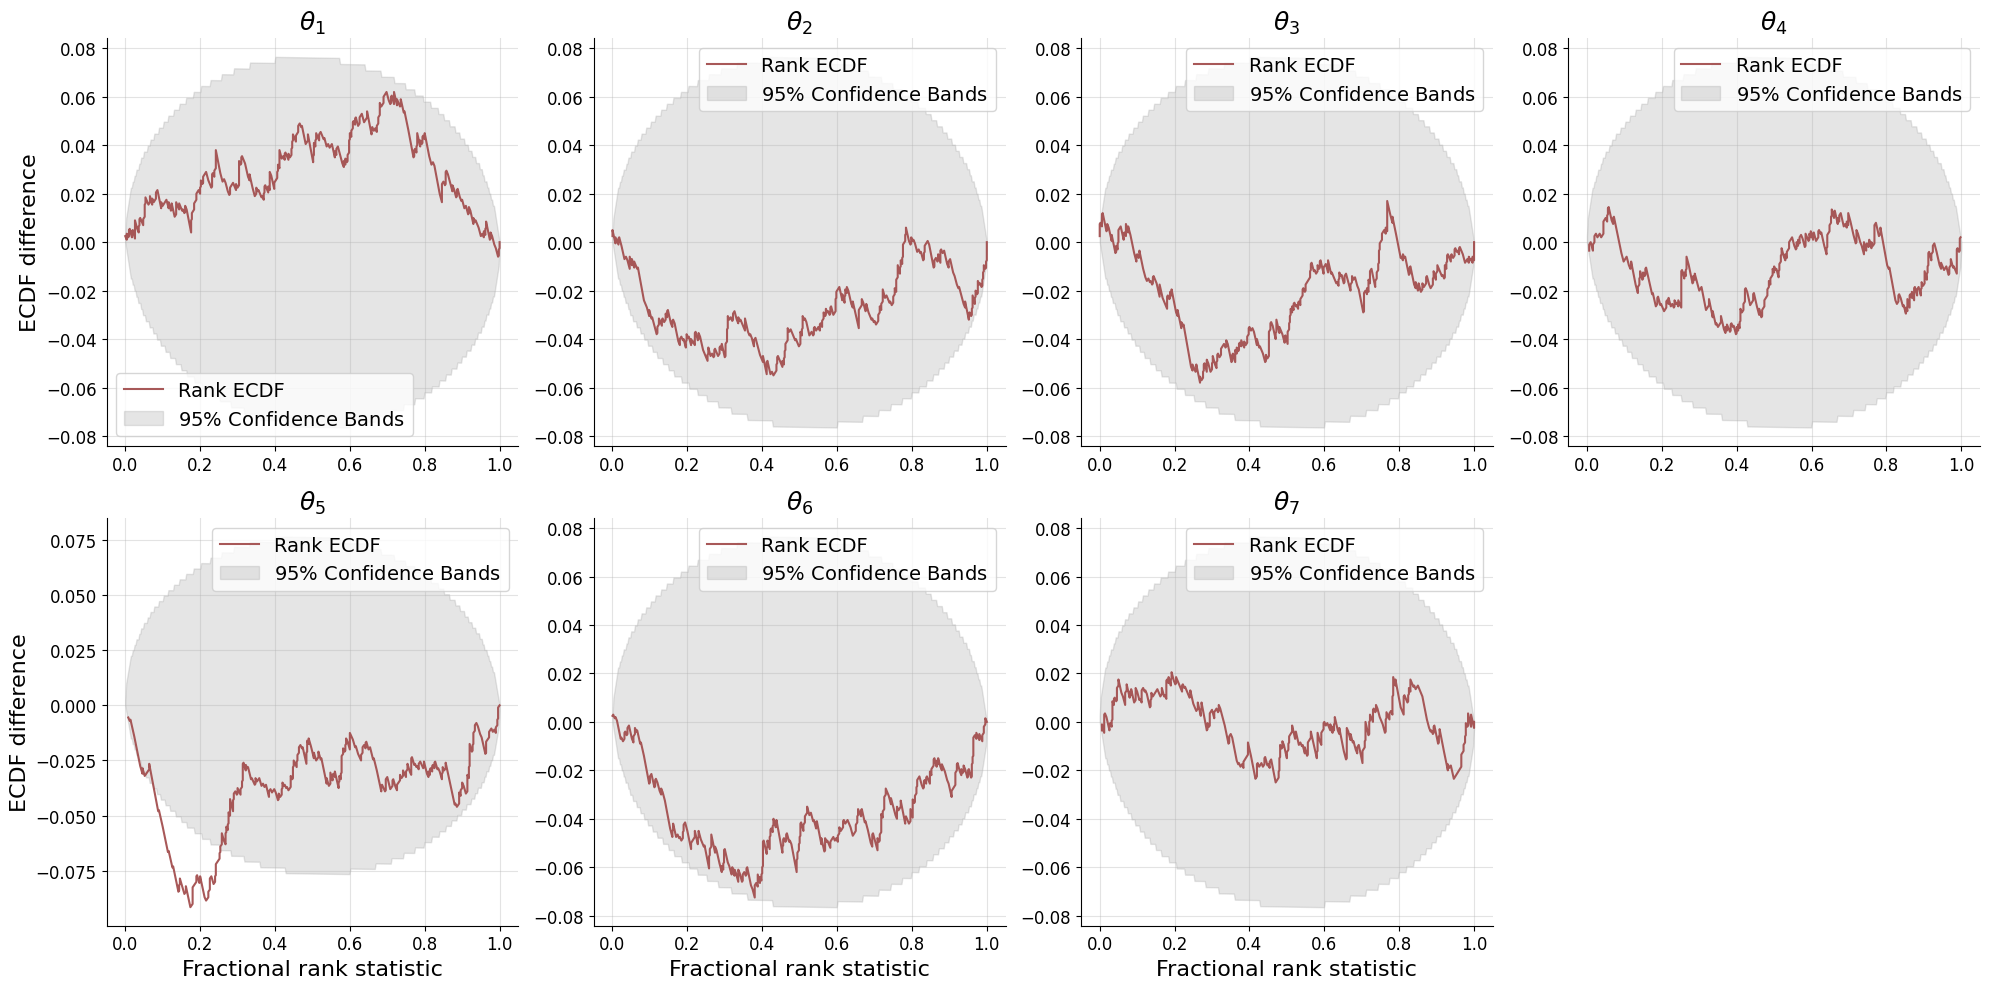

In [15]:
f = bf.diagnostics.plot_sbc_ecdf(samples, conf['parameters'], difference=True)